The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading frames 1 to 21


frame:   0%|          | 0/20 [00:00<?, ?it/s]

Frameset: wr_210522_256_left, 20 frames with 9 channels JIT enabled
Loading frames 1 to 21


frame:   0%|          | 0/20 [00:00<?, ?it/s]

Frameset: wr_210522_256_center, 20 frames with 9 channels JIT enabled
Loading frames 1 to 21


frame:   0%|          | 0/20 [00:00<?, ?it/s]

Frameset: wr_210522_256_right, 20 frames with 9 channels JIT enabled
Frameset: wr_210522_256_left_rgb, 20 frames with 1 channels JIT enabled
Frameset: wr_210522_256_right_rgb, 20 frames with 1 channels JIT enabled
Frameset: wr_210522_256_center_depth, 20 frames with 1 channels JIT enabled
(16, 256, 256, 3)
(4, 256, 256, 3)
(16, 256, 256, 3)
(4, 256, 256, 3)
(16, 256, 256, 3)
(4, 256, 256, 3)


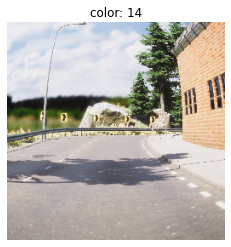

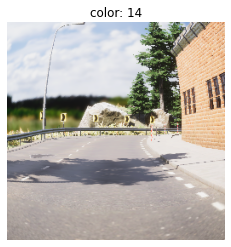

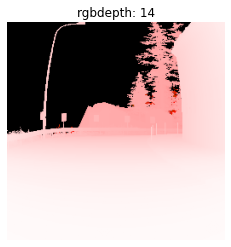

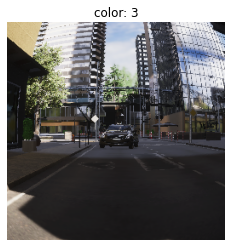

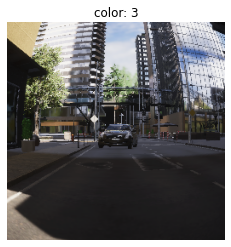

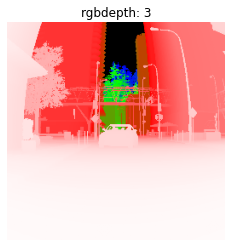

In [14]:
%load_ext autoreload
%autoreload 2

# load new frame-set

from repos.pyjunk.junktools.frameset import frameset

g_fVerbose = False
g_fJITLoading = True
frameset_res = 256
strFramesetBaseName = 'wr_210522'
strFramesetName_left = strFramesetBaseName + '_' + str(frameset_res) + '_left'
strFramesetName_right = strFramesetBaseName + '_' + str(frameset_res) + '_right'
strFramesetName_center = strFramesetBaseName + '_' + str(frameset_res) + '_center'
batch_size = 128
test_batch_size = 10
num_frames = None
#num_frames = 4900
#num_frames = 100
num_frames = 20

frameset_left = frameset(strFramesetName_left, num_frames=num_frames, fJITLoading=g_fJITLoading, fVerbose=g_fVerbose)
frameset_left.Print()

frameset_center = frameset(strFramesetName_center, num_frames=num_frames, fJITLoading=g_fJITLoading, fVerbose=g_fVerbose)
frameset_center.Print()

frameset_right = frameset(strFramesetName_right, num_frames=num_frames, fJITLoading=g_fJITLoading, fVerbose=g_fVerbose)
frameset_right.Print()

# Split up into RGB and respective target framesets
frameset_left_rgb = frameset(
    sourceFrameset=frameset_left, 
    strNewFramesetName=strFramesetName_left + "_rgb", 
    sourceChannels=['Color']
)

frameset_right_rgb = frameset(
    sourceFrameset=frameset_right, 
    strNewFramesetName=strFramesetName_right + "_rgb", 
    sourceChannels=['Color']
)

frameset_center_depth = frameset(
    sourceFrameset=frameset_center, 
    strNewFramesetName=strFramesetName_center + "_depth", 
    sourceChannels=['RGBDepth']
)

frameset_left_rgb.Print()
#print(frameset_left_rgb.shape())
#frameset_left_rgb[0].visualize()

frameset_right_rgb.Print()
#frameset_right_rgb[0].visualize()

frameset_center_depth.Print()
#frameset_center_depth[0].visualize()

# split into train and test

frameset_left_rgb_train, frameset_left_rgb_test = frameset_left_rgb.split_into_train_and_test(0.8)
print(frameset_left_rgb_train.shape())
print(frameset_left_rgb_test.shape())
train_idx = frameset_left_rgb_train.get_frame_ids()
test_idx = frameset_left_rgb_test.get_frame_ids()

frameset_right_rgb_train, frameset_right_rgb_test = frameset_right_rgb.split_into_train_and_test(train_indices=train_idx, test_indices=test_idx)
print(frameset_right_rgb_train.shape())
print(frameset_right_rgb_test.shape())

frameset_center_depth_train, frameset_center_depth_test = frameset_center_depth.split_into_train_and_test(train_indices=train_idx, test_indices=test_idx)
print(frameset_center_depth_train.shape())
print(frameset_center_depth_test.shape())

# Confirm the match-up
frameset_left_rgb_train[3].visualize()
frameset_right_rgb_train[3].visualize()
frameset_center_depth_train[3].visualize()

frameset_left_rgb_test[1].visualize()
frameset_right_rgb_test[1].visualize()
frameset_center_depth_test[1].visualize()

In [15]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn

# Conv U-Net

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.StereoConvUNet import StereoConvUNet
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.StereoConvUNetTorchSolver import StereoConvUNetTorchSolver
from repos.pyjunk.models.modules.SSIMModule import SSIMModule

# Set up model
num_left_rgb, H_left_rgb, W_left_rgb, C_left_rgb = frameset_left_rgb_train.shape()
num_right_rgb, H_right_rgb, W_right_rgb, C_right_rgb = frameset_right_rgb_train.shape()
num_center_depth, H_center_depth, W_center_depth, C_center_depth = frameset_center_depth_train.shape()

batch_size = 128
test_batch_size = 5

print("input dims: %d, %d, %d" % (H_left_rgb, W_left_rgb, C_left_rgb))
print("target dims: %d, %d, %d" % (H_center_depth, W_center_depth, C_center_depth))

modelConvUNet = StereoConvUNet(
    input_shape=(H_left_rgb, W_left_rgb, C_left_rgb),
    output_shape=(H_center_depth, W_center_depth, C_center_depth),
    scale=3, 
    num_filters=32
)

# modelConvUNet = ConvUNet(
#     input_shape=(H_low_rgb, W_low_rgb, C_low_rgb),
#     scale=3, 
#     num_filters=32
# )

# # test SSIM
# testSSIM = SSIMModule(
#     window_size=11, 
#     sigma=1.5
# )

# # # SSIM on same image should be approx 1.0
# npFrameBuffer = primitives_high_res_rgb_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0)
# torchImageBuffer = torchImageBuffer.permute(0, 3, 1, 2)
# ssim_val = testSSIM.forward(torchImageBuffer, torchImageBuffer)
# print(ssim_val)

# # Test model
# npFrameBuffer = primitives_high_res_rgb_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0)
# #print(torchImageBuffer.shape)
# torchImageBuffer = torchImageBuffer.permute(0, 3, 1, 2)
# out, skip = modelConvUNet.encoder.forward(torchImageBuffer)
# x_tild = modelConvUNet.decoder.forward(out, skip)

# # Test model loss
# npFrameBuffer = primitives_high_res_rgb_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0)
# loss = modelConvUNet.loss(torchImageBuffer, torchImageBuffer)
# print(loss)

# Set up the solver
strCheckpointName = "stereo_recon_unet.tar"
strCheckpointTestName = "stereo_recon_unet.png"
dictSolverParams = {
    'lr': 1e-4,
    'epochs': 10000,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
    'checkpoint_file_name': strCheckpointName,
    'checkpoint_epochs': 10,
    'save_test_file_name': strCheckpointTestName
}

# Train on frameset 
# TODO: This is just reconstructing the dataset
solver = StereoConvUNetTorchSolver(modelConvUNet, dictSolverParams)

# Lets target the id low res bruv
#solver.train_frameset_and_plot_losses(
#    train_left_frameset=frameset_left_rgb_train, 
#    train_right_frameset=frameset_right_rgb_train, 
#    train_target_frameset=frameset_center_depth_train,
#    test_left_frameset=frameset_left_rgb_test, 
#    test_right_frameset=frameset_right_rgb_test, 
#    test_target_frameset=frameset_center_depth_test,
#    fVerbose=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
input dims: 256, 256, 3
target dims: 256, 256, 3
3
enc first: 3 - 32
enc inner: 32 - 64
enc final: 64 - 128
3
enc first: 3 - 32
enc inner: 32 - 64
enc final: 64 - 128
dec first: 256 - 64
dec inner: 192 - 64 - 32
dec final: 96 - 32 - 3


In [6]:
import torch

solver.SaveCheckpoint(strCheckpointName , 0, 0)

In [6]:
import torch

solver.LoadCheckpoint(strCheckpointName )

(0, 0)

In [16]:
import torch

dictSolverParams = {
    'lr': 1e-4,
    'epochs': 10000,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
    'checkpoint_file_name': strCheckpointName,
    'checkpoint_epochs': 10,
    'save_test_file_name': strCheckpointTestName
}

solver.train_frameset_and_plot_losses(
    train_left_frameset=frameset_left_rgb_train, 
    train_right_frameset=frameset_right_rgb_train, 
    train_target_frameset=frameset_center_depth_train,
    test_left_frameset=frameset_left_rgb_test, 
    test_right_frameset=frameset_right_rgb_test, 
    test_target_frameset=frameset_center_depth_test,
    fVerbose=True)

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

training on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/4 [00:00<?, ?it/s]

training on frame:   0%|          | 0/16 [00:00<?, ?it/s]

testing on frame:   0%|          | 0/4 [00:00<?, ?it/s]

training on frame:   0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


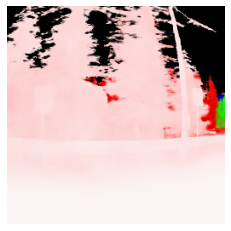

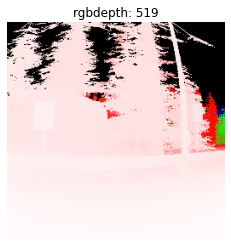

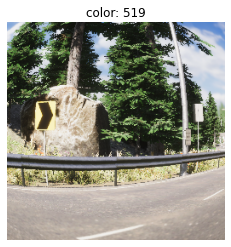

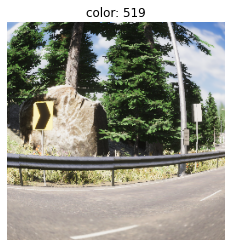

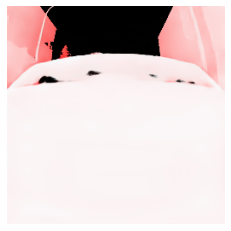

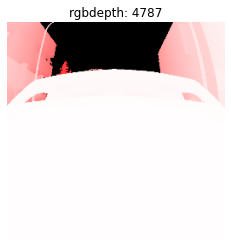

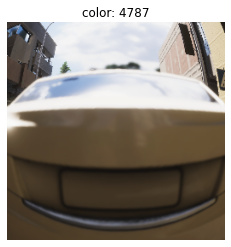

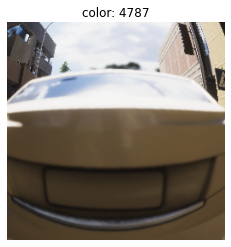

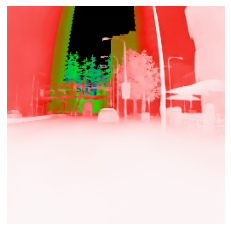

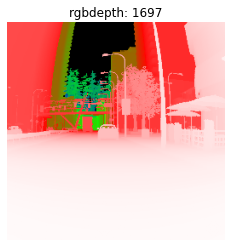

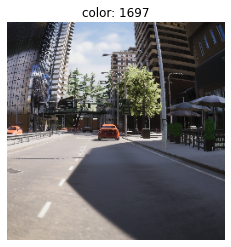

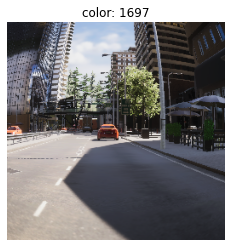

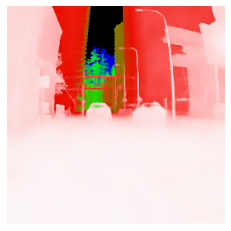

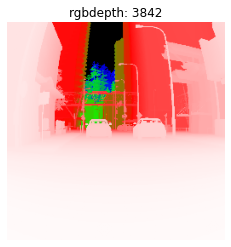

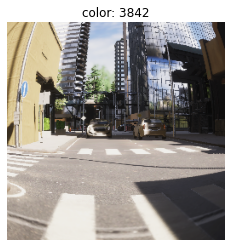

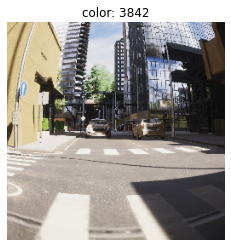

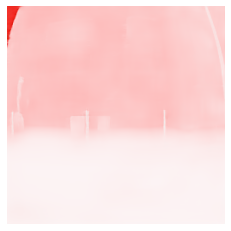

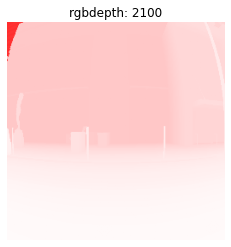

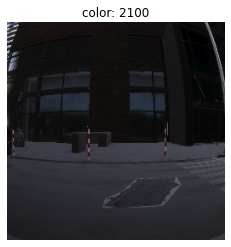

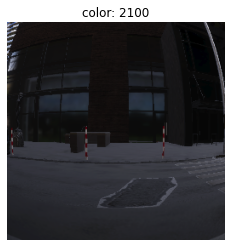

In [8]:
import random

n_frames = 5

for n in range(n_frames):
    frameid = random.randint(0, frameset_left_rgb_test.num_frames - 1)

    # test the forward pass
    fwdPassImg = modelConvUNet.forward_with_frame(frameset_left_rgb_test[frameid], frameset_right_rgb_test[frameid])
    fwdPassImg.visualize()
    frameset_center_depth_test[frameid].visualize()
    frameset_left_rgb_test[frameid].visualize()
    frameset_right_rgb_test[frameid].visualize()
